In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from surprise import accuracy
from surprise import KNNBasic
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import PredefinedKFold, GridSearchCV, train_test_split, cross_validate

In [2]:
'''
http://files.grouplens.org/datasets/movielens/ml-100k-README.txt
'''

# Attributes in the data file are tab separated (\t).
# User = user_id
# Item = item_id
# Rating = rating
# Timestamp = timestamp
reader = Reader(line_format="user item rating timestamp", sep="\t", rating_scale=(1,5))

train_set = Dataset.load_from_file('./ml-100k/u1.base', reader=reader)

In [3]:
# SVD = Singular Value Decomposition
algorithm = KNNBasic()

# Run 5-fold cross-validation and print results
baseline_results = cross_validate(algorithm, train_set, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9888  0.9947  0.9902  0.9955  0.9703  0.9879  0.0091  
MAE (testset)     0.7817  0.7838  0.7821  0.7891  0.7677  0.7809  0.0071  
Fit time          0.29    0.30    0.32    0.32    0.31    0.31    0.01    
Test time         2.87    2.96    2.94    3.13    3.08    2.99    0.09    


##### Tune the model

In [5]:
param_grid = {'k': [i for i in range(40, 130, 10)],
              'min_k': [1, 2, 3, 4, 5],
              'sim_options': {'name': ['msd', 'cosine', 'pearson']},
              'verbose': [False]
             }
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(train_set)

In [6]:
gs.best_params

{'rmse': {'k': 40,
  'min_k': 2,
  'sim_options': {'name': 'msd', 'user_based': True},
  'verbose': False},
 'mae': {'k': 40,
  'min_k': 2,
  'sim_options': {'name': 'msd', 'user_based': True},
  'verbose': False}}

In [7]:
gs.best_score

{'rmse': 0.9873639187488035, 'mae': 0.7813786326059083}

In [8]:
tuning_results = pd.DataFrame.from_dict(gs.cv_results)

In [13]:
tuning_results["sim_type"] = tuning_results["param_sim_options"].apply(lambda x: x['name'])

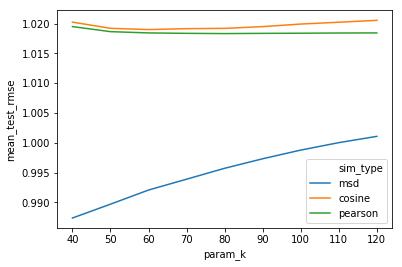

In [22]:
sns.lineplot(x="param_k", y="mean_test_rmse", hue="sim_type", data=tuning_results[tuning_results["param_min_k"] == 2])

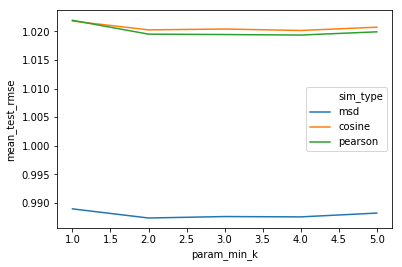

In [24]:
sns.lineplot(x="param_min_k", y="mean_test_rmse", hue="sim_type", data=tuning_results[tuning_results["param_k"] == 40])

##### Compare performance between baseline and tuned models on test set

In [15]:
# Load test set
folds_files = [("./ml-100k/u1.base", "./ml-100k/u1.test")]
data = Dataset.load_from_folds(folds_files, reader=reader)
pkf = PredefinedKFold()

test_set = None
for _, s in pkf.split(data):
    test_set = s

In [16]:
# Baseline model
accuracy.rmse(algorithm.test(test_set))

RMSE: 1.0033


1.003263899395218

In [17]:
# Tuned model
tuned_model = gs.best_estimator["rmse"]
tuned_model.fit(train_set.build_full_trainset())

In [18]:
accuracy.rmse(tuned_model.test(test_set))

RMSE: 0.9894


0.9893940933359827

Although the baseline model and the tuned model perform similarly on the validation set, the RMSE of the tuned model is slightly less than that of the baseline on the test set